## Markov chain simulation of time to coalescence

* My Drive/GitHub/transmission_ms/coalescence_time_basic.ipynb
* Checked in working order 28 Nov 2022
* From 221029_Tc_distribution.ipynb

This code computes the probability distribution time to coalescence of two alleles. 
* We sample two alleles and follow their lineages back in time for `tsim` generations.

We start by specifying the transmission parameters and the duration of the simulation
* `N` is the effective number of hosts
* `X` is the crossing rate of transmission chains
* `Q` is the quantum of transmission
* `t_sim` is the duration of the simulation in generations

We use the transmission parameters to construct a matrix of transition probabilities
* `transition` is a 3x3 matrix with the transition probabilities

We create arrays to record the state of two lineages as we progress back in time
* `beho_lineage` and `wiho_lineage` are two-dimensional arrays
* they record a probability vector [Pr{separated}, Pr{cotransmitted}, Pr{coalesced}] for each time point
* these are *backwards time series* arrays, meaning that the most recent generation appears as the first item on the time axis.

We specify the initial conditions of the simulation
* To study *between-host variation* we specify that Pr{separated} = 1 at the start of the simulation (i.e. we sample two alleles from different hosts)
* To study *within-host variation* we specify that Pr{cotransmitted} = 1 at the start of the simulation (i.e. we sample two alleles from the same host)

We work out the probability vector for each successive time point by matrix multiplication then we plot the results.

We work out the mean time to coalescence.
* For this we create an array called `tcdist` that records the probability of coalescence occurring at each time point

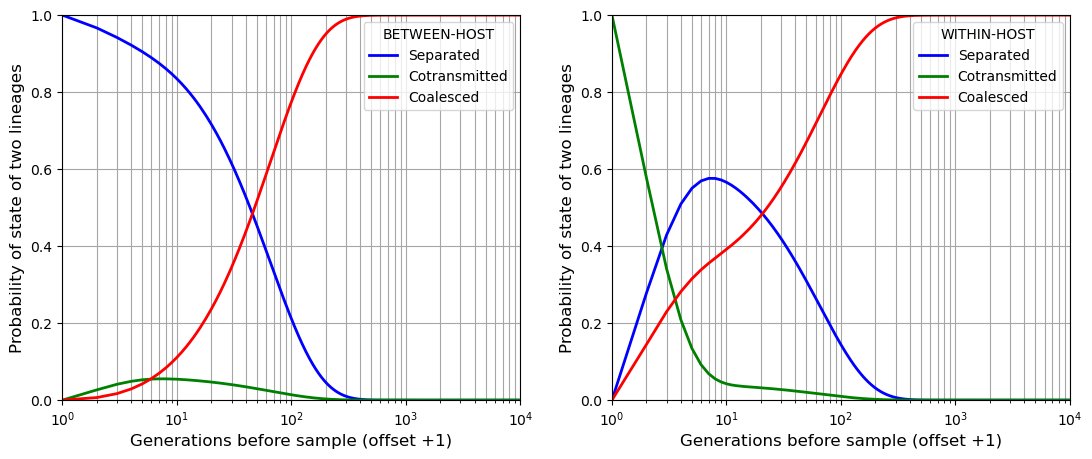

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

# SPECIFY THE TRANSMISSION PARAMETERS

N = 30  # Effective number of hosts.
X = 0.5 # Crossing rate of transmission chains
Q = 5   # Quantum of transmission.

# SPECIFY THE DURATION OF THE SIMULATION IN GENERATIONS

tsim = 10000

# CREATE A MATRIX OF TRANSITION PROBABILITIES

transition = np.ones((3,3))

transition[0,:] = [1 - (1 / N), 
                   (Q - 1) / (N * Q),
                    1 / (N * Q)]

transition[1,:] = [Q * X / (2*Q - 1),
                  (Q - 1) * (2*Q - Q*X - 1) / (Q * (2*Q - 1)), 
                  (2*Q - Q*X - 1) / (Q * (2*Q - 1))]

transition[2,:] = [0, 0, 1]

# CREATE ARRAYS TO TRACK THE STATE OF TWO LINEAGES AS WE PROGRESS BACK IN TIME

beho_lineage = np.zeros((tsim + 1, 3)) # an array for analysing between-host variation

wiho_lineage = np.zeros((tsim + 1, 3))  # an array for analysing within-host variation 

    # [t,0] Pr{Separated} at time t
    # [t,1] Pr{Cotransmitted}
    # [t,2] Pr{Coalesced}
    
# To study between-host variation we specify that at t=0 the lineages are separated

beho_lineage[0,:] = [1, 0, 0]

# To study within-host variation we specify that at t=0 the lineages are cotransmitted

wiho_lineage[0,:] = [0, 1, 0]
    
# PERFORM THE SIMULATION BY MATRIX MULTIPLICATION

for t in range(1, tsim + 1):

    beho_lineage[t,:] = np.matmul(beho_lineage[t-1,:], transition[:,:])
    
    wiho_lineage[t,:] = np.matmul(wiho_lineage[t-1,:], transition[:,:])
    
# DISPLAY THE PROBABILITY OF EACH STATE OVER TIME

# To allow log scale for time we offset the horizontal axis by +1.  Thus t=1 is the time of sampling alleles.

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.plot(range(1,tsim + 2), beho_lineage[:,0], marker='', color='blue', linewidth=2, label="Separated")
plt.plot(range(1,tsim + 2), beho_lineage[:,1], marker='', color='green', linewidth=2, label="Cotransmitted")
plt.plot(range(1,tsim + 2), beho_lineage[:,2], marker='', color='red', linewidth=2, label="Coalesced")
plt.xlabel("Generations before sample (offset +1)", fontsize=12)
plt.ylabel("Probability of state of two lineages", fontsize=12)
plt.xscale('log',base=10) 
plt.grid(visible=True, which='both', color='0.65', linestyle='-')
plt.axis([1, tsim, 0, 1])
plt.legend(title="BETWEEN-HOST", frameon=True) # can add (title="Title", frameon=False) 

plt.subplot(1,2,2)
plt.plot(range(1,tsim + 2), wiho_lineage[:,0], marker='', color='blue', linewidth=2, label="Separated")
plt.plot(range(1,tsim + 2), wiho_lineage[:,1], marker='', color='green', linewidth=2, label="Cotransmitted")
plt.plot(range(1,tsim + 2), wiho_lineage[:,2], marker='', color='red', linewidth=2, label="Coalesced")
plt.xlabel("Generations before sample (offset +1)", fontsize=12)
plt.ylabel("Probability of state of two lineages", fontsize=12)
plt.xscale('log',base=10) 
plt.grid(visible=True, which='both', color='0.65', linestyle='-')
plt.axis([1, tsim, 0, 1])
plt.legend(title="WITHIN-HOST", frameon=True) # can add (title="Title", frameon=False) 

plt.show()

Mean time to coalescence
   for alleles sampled from different hosts:  67.3 generations
   for alleles sampled from the same host:  46.7 generations


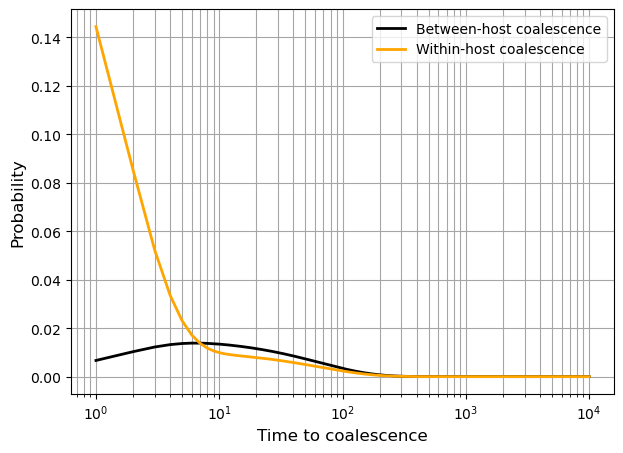

In [2]:
# WORK OUT THE PROBABILITY DISTRIBUTION OF COALESCENCE TIME

tc_dist = np.zeros((tsim + 1, 5))

 # [0] Time
 # [1] Between-host: Probabilility that coalescence occurs in this generation
 # [2] Between-host: Time * (Probability that coalescence occurs in this generation)
 # [3] Within-host: Probabilility that coalescence occurs in this generation
 # [4] Within-host: Time * (Probability that coalescence occurs in this generation)

tc_dist[:,0] = range(0, tsim + 1)
tc_dist[1:tsim + 1, 1] = beho_lineage[1:tsim + 1, 2] - beho_lineage[0:tsim, 2]
tc_dist[:,2] = tc_dist[:,1] * tc_dist[:,0] 
tc_dist[1:tsim + 1, 3] = wiho_lineage[1:tsim + 1, 2] - wiho_lineage[0:tsim, 2]
tc_dist[:,4] = tc_dist[:,3] * tc_dist[:,0]
    
tc_between_host = sum(tc_dist[:,2]) # Mean time to coalescence for between-host variation
tc_within_host = sum(tc_dist[:,4])  # Mean time to coalescence for within-host variation

print("Mean time to coalescence")
print("   for alleles sampled from different hosts: {0:5.1f} generations".format(tc_between_host))
print("   for alleles sampled from the same host: {0:5.1f} generations".format(tc_within_host))

plt.figure(figsize = (7,5))

plt.plot(tc_dist[1:,0], tc_dist[1:,1], marker='', color='black', linewidth=2, label="Between-host coalescence")
plt.plot(tc_dist[1:,0], tc_dist[1:,3], marker='', color='orange', linewidth=2, label="Within-host coalescence")
plt.xlabel("Time to coalescence", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.xscale('log',base=10) 
plt.grid(visible=True, which='both', color='0.65', linestyle='-')
# plt.axis([1, tsim, 0 , 1 ])
plt.legend(frameon=True) # can add (title="Title", frameon=False)

plt.show()